In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras


#2.14.0 or later
print(tf.__version__)


2.14.0


#### Load Dataset

In [2]:
def preprocess_data( X, y):

    X = X.reshape(X.shape[0], 32, 32, 3)
    X = X.astype("float32")
    X = X/255.

    y = tf.keras.utils.to_categorical(y, 10)
    return X, y

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(32, 32, 3)


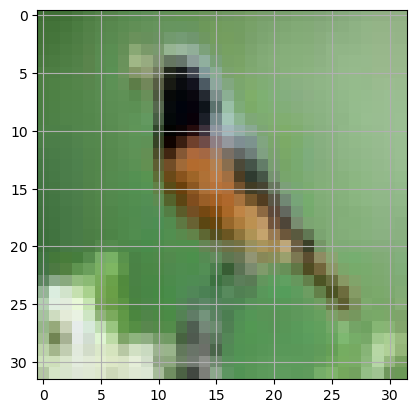

In [5]:
image_id = 75 # Image index in the test set
plt.grid()
print(x_test[image_id].shape)
plt.imshow(x_test[image_id])
plt.show()

In [6]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
        #print(xs.shape)
        #print(xs)
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    #print("tile : ",(tile))
    #print("imgs : ",imgs.shape)
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        #print("pixels ", (pixels))
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

In [7]:
pixel = np.array([16, 16, 255, 255, 0])
result = perturb_image(pixel, x_test[image_id])
print(result.shape)

(1, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


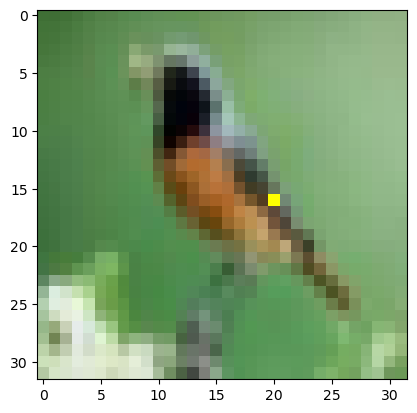

In [8]:
image_id = 75 
pixel = np.array([16, 20,100, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]
plt.imshow(image_perturbed)

### tf and check GPU backend

In [9]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-07-11 02:24:42.814312: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-07-11 02:24:42.814331: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-07-11 02:24:42.814338: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-07-11 02:24:42.814367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-11 02:24:42.814382: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPool2D,Dropout, BatchNormalization

input_shape = (32,32,3)
model = tf.keras.models.Sequential([
    Conv2D(32,kernel_size=(3,3),activation = 'relu', padding = 'same',input_shape = input_shape),
    BatchNormalization(),
    Conv2D(32,kernel_size=(3,3),activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2)),
   
    
    Conv2D(64,kernel_size=(3,3),activation = 'relu', padding = 'same'),
    BatchNormalization(),
    Conv2D(64,kernel_size=(3,3),activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size = (2,2)),

    Flatten(),
    Dense(128,activation = 'relu'),
    Dense(128,activation = 'relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')]

)
model.summary()

2024-07-11 02:24:42.833183: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-11 02:24:42.833197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt = SGD(learning_rate=0.001, momentum=0.9)
#model.compile(optimizer=opt,loss=loss_fn, metrics=["accuracy"])

model.compile(optimizer=Adam(lr=0.001), loss=loss_fn, metrics=["accuracy"])

import time
start_time = time.time()
history = model.fit(x_train, y_train, epochs=20,
           validation_data = (x_test,y_test), batch_size=128)
print(time.time()- start_time)

Epoch 1/20


/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-07-11 02:24:43.840157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-11 02:24:43.899778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


391/391 [==============================] - 8s 19ms/step - loss: 9.0343 - accuracy: 0.3062 - val_loss: 4.2913 - val_accuracy: 0.2996
Epoch 2/20
391/391 [==============================] - 7s 18ms/step - loss: 3.5324 - accuracy: 0.4552 - val_loss: 1.4544 - val_accuracy: 0.5912
Epoch 3/20
391/391 [==============================] - 7s 19ms/step - loss: 1.8922 - accuracy: 0.5182 - val_loss: 1.3021 - val_accuracy: 0.5903
Epoch 4/20
391/391 [==============================] - 7s 18ms/step - loss: 1.4215 - accuracy: 0.5669 - val_loss: 1.1600 - val_accuracy: 0.6048
Epoch 5/20
391/391 [==============================] - 7s 18ms/step - loss: 1.2513 - accuracy: 0.6026 - val_loss: 1.0213 - val_accuracy: 0.6482
Epoch 6/20
391/391 [==============================] - 7s 18ms/step - loss: 1.1601 - accuracy: 0.6327 - val_loss: 1.4116 - val_accuracy: 0.5971
Epoch 7/20
391/391 [==============================] - 7s 19ms/step - loss: 1.1556 - accuracy: 0.6474 - val_loss: 1.0282 - val_accuracy: 0.6790
Epoch 8/20

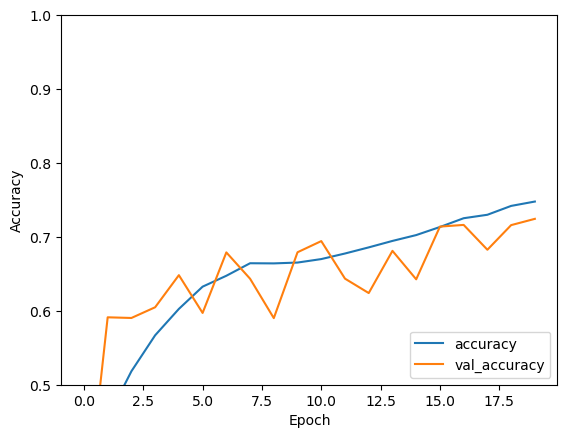

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 11ms/step
Predicted label :  bird
Confidence :  0.99999654


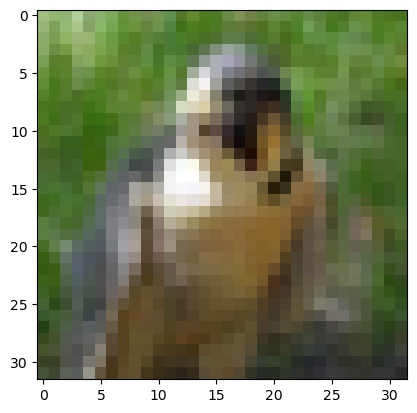

In [51]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156]) 

test_img = x_test[image_id]
reshaped_img = np.array([test_img])

true_class = y_test[image_id, 0]


prior_confidence = model.predict(reshaped_img,batch_size =1)[0]
result_index = (np.argmax(prior_confidence))
print("Predicted label : ",class_names[result_index])
print("Confidence : ",prior_confidence[result_index])
plt.imshow(test_img)

#### Sample Attack


In [54]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)


    reshaped_img = np.array([img])

    predicted_result = model.predict(reshaped_img,batch_size =1)[0]
    predicted_class = (np.argmax(predicted_result))

    confidence =confidence[predicted_class]

    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

In [56]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])


true_class = y_test[image_id]
print(true_class)
prior_confidence = model.predict(x_test[image_id],batch_size =1)[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)


0.0


InvalidArgumentError: Graph execution error:

Detected at node sequential/conv2d/Relu defined at (most recent call last):
  File "/opt/anaconda3/envs/ths/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/anaconda3/envs/ths/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/anaconda3/envs/ths/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/anaconda3/envs/ths/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/anaconda3/envs/ths/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/xd/3z5vvpds0zxf_pypxd4cn3d80000gn/T/ipykernel_4761/2584061146.py", line 7, in <module>

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/opt/anaconda3/envs/ths/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu

input must be 4-dimensional[1,32,3]
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_predict_function_43247]